In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
from itertools import combinations

In [134]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
columns_not_needed_80 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avt_favorite_count', 'total_replies',
                        'tweet_num_replies_ratio', 'max_number_of_tweet_in_a_day', 'total_likes',
                        'total_retweet_count', 'tweet_num_likes_ratio', 'number_of_tweets', 
                        'avg_text_length', 'statuses_count', 'day_with_most_tweets']
columns_not_needed_70 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avg_text_length', 'max_number_of_tweet_in_a_day',
                        'number_of_tweets', 'total_likes', 'total_replies', 'tweet_num_replies_ratio',
                        'statuses_count', 'day_with_most_tweets']

users_df_70 = users_df[users_df.columns.difference(columns_not_needed_80)]
users_df_80 = users_df[users_df.columns.difference(columns_not_needed_70)]

users_df_70.info()
users_df_80.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   account_average_tweets_per_day     11109 non-null  float64
 1   account_discussion_creation_ratio  11109 non-null  float64
 2   avg_hashtags                       11109 non-null  float64
 3   avg_mentions                       11109 non-null  float64
 4   avg_special_char_in_text           11109 non-null  float64
 5   avt_reply_count                    11109 non-null  float64
 6   entropy_for_day                    11109 non-null  float64
 7   entropy_for_hour                   11109 non-null  float64
 8   entropy_for_minute                 11109 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 12 columns):
 #   Column                          

# KMeans

In [142]:
all_possible_combinations = list(combinations(users_df_70.columns, 2))
combination = ['entropy_for_minute', 'account_discussion_creation_ratio']
subset_df = users_df[all_possible_combinations]
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result = scaler.fit_transform(subset_df.values)

KeyError: "None of [Index([('account_average_tweets_per_day', 'account_discussion_creation_ratio'),\n                            ('account_average_tweets_per_day', 'avg_hashtags'),\n                            ('account_average_tweets_per_day', 'avg_mentions'),\n                ('account_average_tweets_per_day', 'avg_special_char_in_text'),\n                         ('account_average_tweets_per_day', 'avt_reply_count'),\n                         ('account_average_tweets_per_day', 'entropy_for_day'),\n                        ('account_average_tweets_per_day', 'entropy_for_hour'),\n                      ('account_average_tweets_per_day', 'entropy_for_minute'),\n                         ('account_discussion_creation_ratio', 'avg_hashtags'),\n                         ('account_discussion_creation_ratio', 'avg_mentions'),\n             ('account_discussion_creation_ratio', 'avg_special_char_in_text'),\n                      ('account_discussion_creation_ratio', 'avt_reply_count'),\n                      ('account_discussion_creation_ratio', 'entropy_for_day'),\n                     ('account_discussion_creation_ratio', 'entropy_for_hour'),\n                   ('account_discussion_creation_ratio', 'entropy_for_minute'),\n                                              ('avg_hashtags', 'avg_mentions'),\n                                  ('avg_hashtags', 'avg_special_char_in_text'),\n                                           ('avg_hashtags', 'avt_reply_count'),\n                                           ('avg_hashtags', 'entropy_for_day'),\n                                          ('avg_hashtags', 'entropy_for_hour'),\n                                        ('avg_hashtags', 'entropy_for_minute'),\n                                  ('avg_mentions', 'avg_special_char_in_text'),\n                                           ('avg_mentions', 'avt_reply_count'),\n                                           ('avg_mentions', 'entropy_for_day'),\n                                          ('avg_mentions', 'entropy_for_hour'),\n                                        ('avg_mentions', 'entropy_for_minute'),\n                               ('avg_special_char_in_text', 'avt_reply_count'),\n                               ('avg_special_char_in_text', 'entropy_for_day'),\n                              ('avg_special_char_in_text', 'entropy_for_hour'),\n                            ('avg_special_char_in_text', 'entropy_for_minute'),\n                                        ('avt_reply_count', 'entropy_for_day'),\n                                       ('avt_reply_count', 'entropy_for_hour'),\n                                     ('avt_reply_count', 'entropy_for_minute'),\n                                       ('entropy_for_day', 'entropy_for_hour'),\n                                     ('entropy_for_day', 'entropy_for_minute'),\n                                    ('entropy_for_hour', 'entropy_for_minute')],\n      dtype='object')] are in the [columns]"

In [136]:
kmeans = KMeans(n_clusters=9, n_init=10, max_iter=150)
kmeans.fit(transform_result)

KMeans(max_iter=150, n_clusters=9)

<BarContainer object of 9 artists>

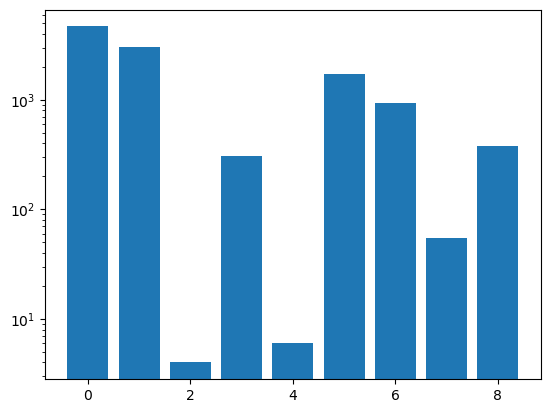

In [137]:
clusters_id, clusters_sizes = np.unique(kmeans.labels_, return_counts=True)

plt.bar(x=clusters_id, height=clusters_sizes, log=True)
plt.show()

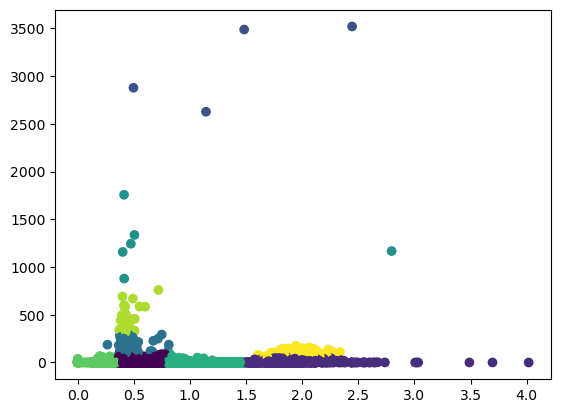

In [138]:
plt.scatter(data=users_df, x=combination[0], y=combination[1],c=kmeans.labels_)
plt.show()

In [139]:
clustering_utils.print_clustering_metrics(kmeans, transform_result)

SSE 1068.7721117803023
Silhouette 0.5484489230564312
Separation 0.5446545294791832



## Running multiple K-means and plotting SSE

Trying to plot the relation between K centroids and SSE. The main problem is: what indica

KMeans(max_iter=150, n_clusters=1)

KMeans(max_iter=150, n_clusters=2)

KMeans(max_iter=150, n_clusters=3)

KMeans(max_iter=150, n_clusters=4)

KMeans(max_iter=150, n_clusters=5)

KMeans(max_iter=150, n_clusters=6)

KMeans(max_iter=150, n_clusters=7)

KMeans(max_iter=150)

KMeans(max_iter=150, n_clusters=9)

KMeans(max_iter=150, n_clusters=10)

KMeans(max_iter=150, n_clusters=11)

KMeans(max_iter=150, n_clusters=12)

KMeans(max_iter=150, n_clusters=13)

KMeans(max_iter=150, n_clusters=14)

KMeans(max_iter=150, n_clusters=15)

KMeans(max_iter=150, n_clusters=16)

KMeans(max_iter=150, n_clusters=17)

KMeans(max_iter=150, n_clusters=18)

KMeans(max_iter=150, n_clusters=19)

KMeans(max_iter=150, n_clusters=20)

KMeans(max_iter=150, n_clusters=21)

KMeans(max_iter=150, n_clusters=22)

KMeans(max_iter=150, n_clusters=23)

KMeans(max_iter=150, n_clusters=24)

KMeans(max_iter=150, n_clusters=25)

KMeans(max_iter=150, n_clusters=26)

KMeans(max_iter=150, n_clusters=27)

KMeans(max_iter=150, n_clusters=28)

KMeans(max_iter=150, n_clusters=29)

KMeans(max_iter=150, n_clusters=30)

<AxesSubplot:xlabel='K'>

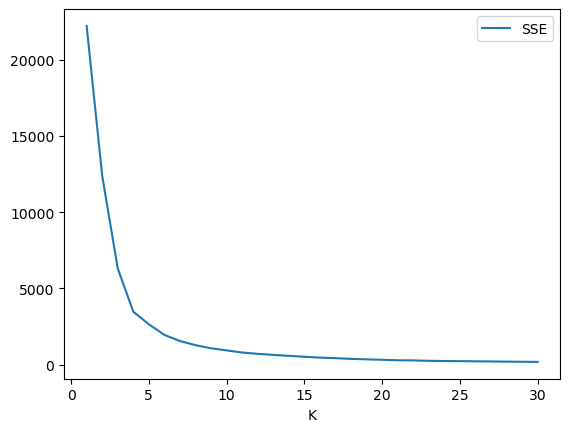

In [140]:
results = []
for k in range(1,31):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=150)
    kmeans.fit(transform_result)
    SSE = kmeans.inertia_
    results.append([k, SSE])
    
results_df = pd.DataFrame(results, columns=["K", "SSE"])
results_df.plot(x="K", y="SSE")